<img src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" style="width:256px" > <img src="https://upload.wikimedia.org/wikipedia/commons/1/12/Cc-by-nc-sa_icon.svg" width=192 align=right>

**Author :** Jean-Christophe Loiseau

**Email :** [jean-christophe.loiseau@ensam.eu](mailto:jean-christophe.loiseau@ensam.eu)

**Date :** June 2025

---

In [1]:
#> Standard Python packages.
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#> Import utility functions.
from scipy.integrate import solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['atol'] = 1e-12

#> PySINDy
import pysindy as ps

#> Bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

/home/loiseau/miniconda3/envs/cea_saclay/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound
/tmp/ipykernel_8618/819277647.py:17: DeprecationWarning: Please import `ODEintWarning` from the `scipy.integrate` namespace; the `scipy.integrate.odepack` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.integrate.odepack import ODEintWarning


# **Nonlinear system identification with PySINDy**

**NOTE :** This notebook is an introduction to the python package `PySINDy`. It is primarily adapted from the example notebooks found in the `PySINDy` Github repo [(here)](https://github.com/dynamicslab/pysindy/tree/master/examples).

## **Introduction**

*SINDy* is a methodology proposed in 2015 in [Brunton *et al.*]() (PNAS, 2015) for the identification of nonlinear dynamics based on sparsity-promoting regression. 

### **Vanilla SINDy**

Let us illustrate the basic usage of `PySINDy` using the classical Lorenz 63 model. This set of ODE reads

$$
\begin{aligned}
    \dot{x} & = \sigma \left( y - x \right) \\
    \dot{y} & = x \left( \rho - z \right) - y \\
    \dot{z} & = x y - \beta z.
\end{aligned}
$$

This seemingly simple system has a long and rich history in nonlinear dynamics and fluid dynamics and is one of the first system identified exhibiting chaotic dynamics. We will use the classical set of parameters $(\sigma, \rho, \beta) = (10, 28, \frac{8}{3})$. This system is such a classic that `PySINDy` provides an implementation of it. The cell below will use it to generate the training and test set for our identification problem.

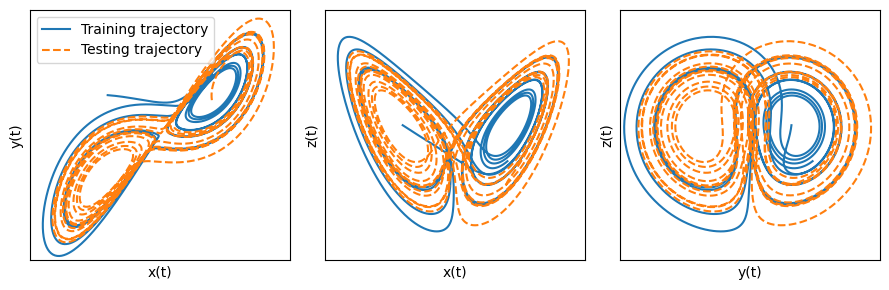

In [2]:
from pysindy.utils import lorenz

#> Time step, time span and initial condition for the training set.
Δt = 0.002 ; t_train = np.arange(0, 10, Δt) ; t_train_span = (t_train[0], t_train[-1])
x0_train = np.array([-8.0, 8.0, 27.0])

#> time span and initial condition for the testing set.
t_test = np.arange(0, 15, Δt) ; t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8.0, 7.0, 15.0])

#> Training set.
x_train = solve_ivp(
    lorenz,
    t_train_span,
    x0_train,
    t_eval=t_train,
    **integrator_keywords
).y.T

#> Test set.
x_test = solve_ivp(
    lorenz,
    t_test_span,
    x0_test,
    t_eval=t_test,
    **integrator_keywords
).y.T

#------------------------------------------------------
#-----     Plot the Lorenz' strange attractor     -----
#------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].plot(x_train[:, 0], x_train[:, 1], label="Training trajectory")
axes[0].plot(x_test[:, 0], x_test[:, 1], ls="--", label="Testing trajectory")
axes[0].set(xlim=(-20, 20), xlabel=r"x(t)")
axes[0].set(ylim=(-25, 25), ylabel=r"y(t)")
axes[0].legend(loc=0)

axes[1].plot(x_train[:, 0], x_train[:, 2])
axes[1].plot(x_test[:, 0], x_test[:, 2], ls="--")
axes[1].set(xlim=(-20, 20), xlabel=r"x(t)")
axes[1].set(ylim=(0, 50), ylabel=r"z(t)")

axes[2].plot(x_train[:, 1], x_train[:, 2])
axes[2].plot(x_test[:, 1], x_test[:, 2], ls="--")
axes[2].set(xlim=(-25, 25), xlabel=r"y(t)")
axes[2].set(ylim=(0, 50), ylabel=r"z(t)")

for ax in axes:
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

#### **Fitting a simple model**

In [3]:
#> Degrees of freedom can be named.
feature_names = ["x", "y", "z"]

#> Use the simplest optimizer (sequential thresholded least-squares with no thresholding...)
optimizer = ps.STLSQ(threshold=0)

#> Instantiate and fit the model.
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train, t=Δt) # Passing t as a constant implies constant time-step.

#> Print the identified equations.
model.print()

(x)' = -0.001 1 + -10.005 x + 10.003 y
(y)' = -0.015 1 + 27.991 x + -0.998 y + 0.002 z + -1.000 x z
(z)' = 0.008 1 + 0.006 x + -0.004 y + -2.666 z + 0.001 x^2 + 0.999 x y


In [4]:
#> Use the simplest optimizer (coefficients smaller than 0.1 in abs are pruned at each iteration)
optimizer = ps.STLSQ(threshold=0.1)

#> Instantiate and fit the model.
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train, t=Δt) # Passing t as a constant implies constant time-step.

#> Print the identified equations.
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [5]:
#> Use the simplest optimizer (coefficients smaller than 1.0 in abs are pruned at each iteration)
optimizer = ps.STLSQ(threshold=1.0)

#> Instantiate and fit the model.
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train, t=Δt) # Passing t as a constant implies constant time-step.

#> Print the identified equations.
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = -2.793 x
(z)' = 0.000


/home/loiseau/miniconda3/envs/cea_saclay/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


##### **How to choose the regularization parameter $\lambda$?**

[(0.01, 100.0), Text(0, 0.5, 'Root mean-squared error')]

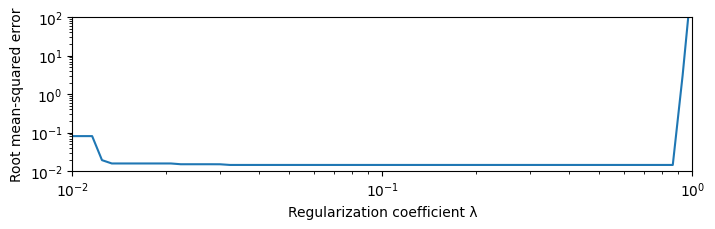

In [6]:
#> Range of regularization parameters.
threshold_range = np.logspace(-2, 0, 64)

#> Metric used to discriminate the models.
from sklearn.metrics import mean_squared_error, root_mean_squared_error

#> Fitting mean-squared error.
mse_fit = np.zeros_like(threshold_range)

#> List of trained models.
models = []

#> Add some noise for more realistic setup.
scale = root_mean_squared_error(x_train, np.zeros_like(x_train))
x_train_added_noise = x_train + np.random.normal(0, scale/100.0, x_train.shape)

for (i, threshold) in enumerate(threshold_range):
    # Instantiate the optimizer.
    optimizer = ps.STLSQ(threshold=threshold)
    
    # Fit the model.
    model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
    model.fit(x_train_added_noise, t=Δt, quiet=True)
    
    # Fitting error.
    mse_fit[i] = model.score(x_test, t=Δt, metric=mean_squared_error)
    
    # Store the model.
    models.append(model)
        
        
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.loglog(threshold_range, mse_fit)
ax.set(xlim=(1e-2, 1), xlabel=r"Regularization coefficient λ")
ax.set(ylim=(1e-2, 1e2), ylabel="Root mean-squared error")

In [7]:
# Instantiate the optimizer.
optimizer = ps.STLSQ(threshold=0.5)

# Fit the model.
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train_added_noise, t=Δt, quiet=True)

# Print identified model.
model.print()

(x)' = -9.958 x + 9.957 y
(y)' = 27.932 x + -0.975 y + -0.999 x z
(z)' = -2.665 z + 1.000 x y


#### **How to compute the time-derivative for SINDy?**

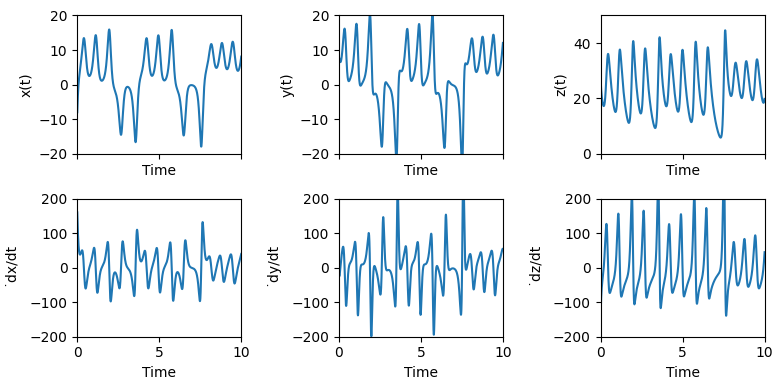

In [8]:
xdot = ps.FiniteDifference()._differentiate(x_train, t_train)
xdot_fd = xdot.copy()

fig, axes = plt.subplots(2, 3, sharex=True, figsize=(8, 4))

axes[0, 0].plot(t_train, x_train[:, 0])
axes[0, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="x(t)")
axes[1, 0].plot(t_train, xdot[:, 0])
axes[1, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dx/dt")

axes[0, 1].plot(t_train, x_train[:, 1])
axes[0, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="y(t)")
axes[1, 1].plot(t_train, xdot[:, 1])
axes[1, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dy/dt")

axes[0, 2].plot(t_train, x_train[:, 2])
axes[0, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(0, 50), ylabel="z(t)")
axes[1, 2].plot(t_train, xdot[:, 2])
axes[1, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dz/dt")

plt.tight_layout()

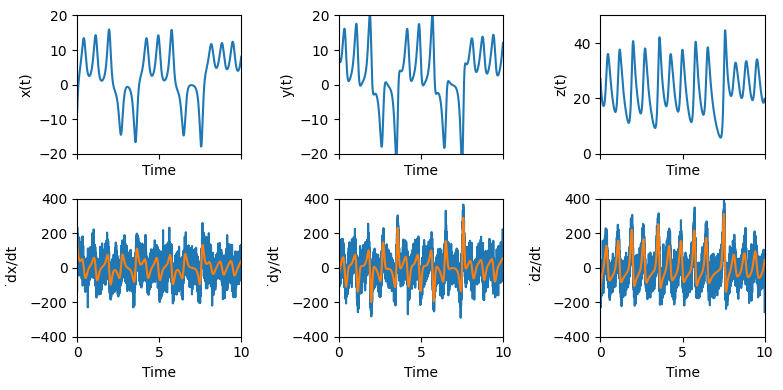

In [9]:
x_train_added_noise = x_train + np.random.normal(0, scale/100, x_train.shape)
xdot = ps.FiniteDifference()._differentiate(x_train_added_noise, t_train)

fig, axes = plt.subplots(2, 3, sharex=True, figsize=(8, 4))

axes[0, 0].plot(t_train, x_train[:, 0])
axes[0, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="x(t)")
axes[1, 0].plot(t_train, xdot[:, 0])
axes[1, 0].plot(t_train, xdot_fd[:, 0])
axes[1, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-400, 400), ylabel="̇dx/dt")

axes[0, 1].plot(t_train, x_train[:, 1])
axes[0, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="y(t)")
axes[1, 1].plot(t_train, xdot[:, 1])
axes[1, 1].plot(t_train, xdot_fd[:, 1])
axes[1, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-400, 400), ylabel="̇dy/dt")

axes[0, 2].plot(t_train, x_train[:, 2])
axes[0, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(0, 50), ylabel="z(t)")
axes[1, 2].plot(t_train, xdot[:, 2])
axes[1, 2].plot(t_train, xdot_fd[:, 2])
axes[1, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(-400, 400), ylabel="̇dz/dt")

plt.tight_layout()

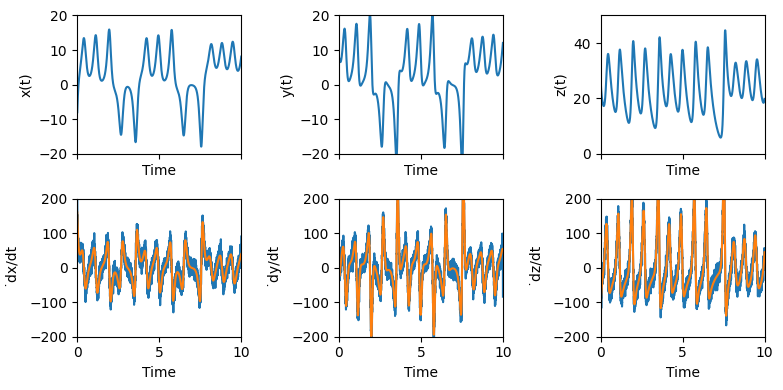

In [10]:
x_train_added_noise = x_train + np.random.normal(0, scale/100, x_train.shape)
xdot = ps.SmoothedFiniteDifference()._differentiate(x_train_added_noise, t_train)

fig, axes = plt.subplots(2, 3, sharex=True, figsize=(8, 4))

axes[0, 0].plot(t_train, x_train[:, 0])
axes[0, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="x(t)")
axes[1, 0].plot(t_train, xdot[:, 0])
axes[1, 0].plot(t_train, xdot_fd[:, 0])
axes[1, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dx/dt")

axes[0, 1].plot(t_train, x_train[:, 1])
axes[0, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="y(t)")
axes[1, 1].plot(t_train, xdot[:, 1])
axes[1, 1].plot(t_train, xdot_fd[:, 1])
axes[1, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dy/dt")

axes[0, 2].plot(t_train, x_train[:, 2])
axes[0, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(0, 50), ylabel="z(t)")
axes[1, 2].plot(t_train, xdot[:, 2])
axes[1, 2].plot(t_train, xdot_fd[:, 2])
axes[1, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dz/dt")

plt.tight_layout()

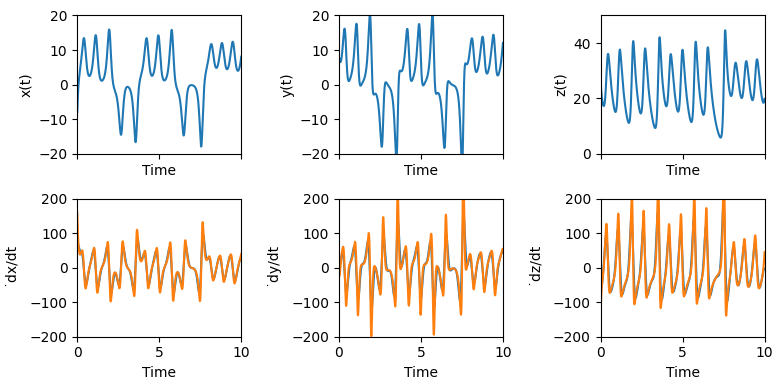

In [11]:
x_train_added_noise = x_train + np.random.normal(0, scale/100, x_train.shape)
xdot = ps.SINDyDerivative(kind="kalman", alpha=0.005)._differentiate(x_train_added_noise, t_train)

fig, axes = plt.subplots(2, 3, sharex=True, figsize=(8, 4))

axes[0, 0].plot(t_train, x_train[:, 0])
axes[0, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="x(t)")
axes[1, 0].plot(t_train, xdot[:, 0])
axes[1, 0].plot(t_train, xdot_fd[:, 0])
axes[1, 0].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dx/dt")

axes[0, 1].plot(t_train, x_train[:, 1])
axes[0, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-20, 20), ylabel="y(t)")
axes[1, 1].plot(t_train, xdot[:, 1])
axes[1, 1].plot(t_train, xdot_fd[:, 1])
axes[1, 1].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dy/dt")

axes[0, 2].plot(t_train, x_train[:, 2])
axes[0, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(0, 50), ylabel="z(t)")
axes[1, 2].plot(t_train, xdot[:, 2])
axes[1, 2].plot(t_train, xdot_fd[:, 2])
axes[1, 2].set(xlim=(0, 10), xlabel=r"Time", ylim=(-200, 200), ylabel="̇dz/dt")

plt.tight_layout()

#### **How to make vanilla SINDy more robust?**

##### **Add more data !**

##### **Use ensemble methods**

In [12]:
# Fit a regular SINDy model with 5% added Gaussian noise
x_train_added_noise = x_train + np.random.normal(0, scale / 20.0,  x_train.shape)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=Δt)
model.print()

(x)' = -9.484 x + 9.583 y
(y)' = 24.392 x + -0.914 x z
(z)' = -2.585 z + 0.974 x y


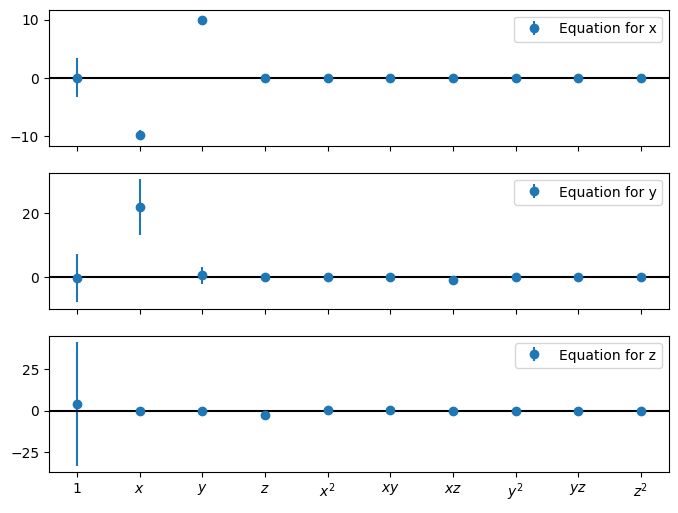

In [13]:
# Fit many SINDy models with 5% added Gaussian noise
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=Δt, ensemble=True, quiet=True)
ensemble_coefs = model.coef_list

# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

xticknames = model.get_feature_names()
for i in range(10):
    xticknames[i] = "$" + xticknames[i] + "$"
    
legend = ["Equation for x", "Equation for y", "Equation for z"]

for i in range(3):
    axes[i].errorbar(range(10), mean_ensemble[i], yerr=std_ensemble[i], fmt="o", label=legend[i])
    axes[i].axhline(0, c="k")
    axes[i].legend(loc=0)
    
axes[-1].set(xticks=np.arange(10), xticklabels=xticknames);

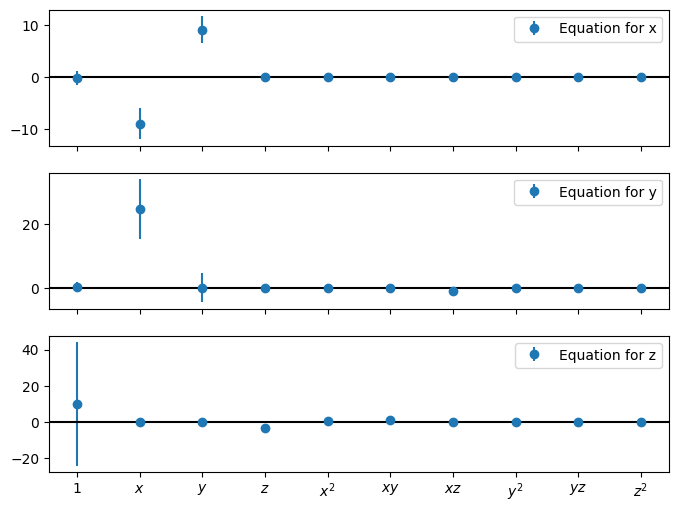

In [14]:
# Now we sub-sample the library, generating multiple models. 
# The default sampling omits a single library term.
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=Δt, library_ensemble=True, quiet=True)
library_ensemble_coefs = model.coef_list

# Get average and standard deviation of the library ensemble model coefficients
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

xticknames = model.get_feature_names()
for i in range(10):
    xticknames[i] = "$" + xticknames[i] + "$"
    
legend = ["Equation for x", "Equation for y", "Equation for z"]

for i in range(3):
    axes[i].errorbar(range(10), mean_library_ensemble[i], yerr=std_library_ensemble[i], fmt="o", label=legend[i])
    axes[i].axhline(0, c="k")
    axes[i].legend(loc=0)
    
axes[-1].set(xticks=np.arange(10), xticklabels=xticknames);

## **Parametrized systems**

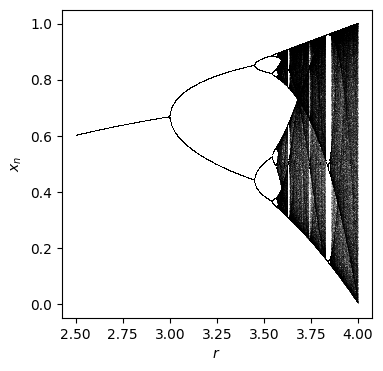

In [15]:
N = 1000
N_drop = 500

r0 = 2.5
rs = np.arange(r0, 4, 0.001)

xss = []

for r in rs:
    xs = []
    x = 0.5
    for n in range(N + N_drop):
        if n >= N_drop:
            xs = xs + [x]
        x = r * x * (1 - x)
    xss = xss + [xs]

plt.figure(figsize=(4, 4), dpi=100)
for ind in range(len(rs)):
    plt.plot(np.ones(N) * rs[ind], xss[ind], ",", alpha=0.1, c="black", rasterized=True)
plt.xlabel("$r$")
plt.ylabel("$x_n$")
plt.show()

In [16]:
# use four parameter values as training data
idx = np.random.choice(len(rs), 5)
rs_train = (rs[idx]).tolist()
xs_train = [np.array(xss[i]) for i in idx]

feature_lib = ps.PolynomialLibrary(degree=3, include_bias=True)
parameter_lib = ps.PolynomialLibrary(degree=2, include_bias=True)
lib = ps.ParameterizedLibrary(
    feature_library=feature_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=1,
)
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib, optimizer=opt, feature_names=["x", "r"], discrete_time=True
)
model.fit(xs_train, u=rs_train, multiple_trajectories=True)
model.print()

(x)[k+1] = 1.000 r[k] x[k] + -1.000 r[k] x[k]^2


## **Identifying Partial Differential Equations**

(x0)' = 0.100 x0_11 + -1.001 x0x0_1


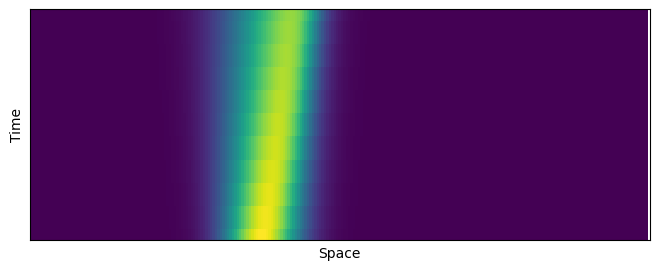

In [17]:
# Load data
from scipy.io import loadmat
data = loadmat("data/burgers.mat")
t = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = t[1] - t[0]
dx = x[1] - x[0]
u_dot = ps.FiniteDifference(axis=-1)._differentiate(u, t=dt)

# Plot the spatiotemporal data
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.pcolormesh(x, t, u.T)
ax.set(xlim=(-8, 8), xlabel="Space", xticks=[])
ax.set(ylim=(0, 1), ylabel="Time", yticks=[])

#> Reshape the data to fit into the PDEFind solver.
u = np.reshape(u, (len(x), len(t), 1))

# Define quadratic library with up to third order derivatives
# on a uniform spatial grid. Do not include a constant term in the function_library!
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, 
                        include_bias=False, is_uniform=True)

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Note that the dimensions of u are reshaped internally,
# according to the dimensions in spatial_grid
model.fit(u, t=dt)
model.print()

## **Various utilities**

### **Using `scikit-learn` optimizers**

### **User-defined library of candidate functions**

### **Acknowledgements**

This work was made possible thanks to the financial support of the French National Agency for Research (ANR) through the ANR-33-CE46-0008-CONMAN grant agreement.

<img src="https://upload.wikimedia.org/wikipedia/fr/c/c3/Nouveau_logo_ANR_2022.jpg" style="width:256px" >